In [1]:
import os
import struct
import numpy as np
import matplotlib.pyplot as plt

def getMNIST(kind = 'train'):
    #Get current path
    path = os.getcwd()
    #Get labels path
    labels_path = os.path.join(path,'%s-labels-idx1-ubyte' % kind)
    #Get images path
    images_path = os.path.join(path,'%s-images-idx3-ubyte' % kind)
    with open(labels_path,'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                             lbpath.read(8))
        labels = np.fromfile(lbpath,dtype = np.uint8)
    with open(images_path,'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII', 
                             imgpath.read(16))
        images = np.fromfile(imgpath,dtype = np.uint8).reshape(len(labels),rows*cols)
        #Pixel normalization
        images = ((images/255)-0.5)*2
    return images,labels

#Get MNIST data : 60000,60000*784,10000,10000*784 respectly.
X_train,y_train = getMNIST(kind = 'train')
X_test,y_test = getMNIST(kind = 't10k')

In [2]:
class MLPNeuralNetwork(object):
    
    def __init__(self,
                 l2 = 0,
                 eta = 0,
                 epochs = 1,
                 shuffle = True,
                 unit_hidden=100,
                 Random_seed = 1,
                 minibatch_size = 100,):
        
        self.l2 = l2
        self.eta = eta
        self.shuffle = shuffle
        self.epochs = epochs
        self.unit_hidden = unit_hidden
        self.minibatch_size = minibatch_size
        self.random = np.random.RandomState(Random_seed)
        self.evaluation = {'cost': [], 'train_acc': [], 'valid_acc': []}
        
    
    def Onehot(self,y):
        # Encode labels into one-hot representation
        num_class = np.unique(y).shape[0]
        lable_size = y.shape[0]
        onehot = np.zeros((lable_size,num_class))
        for ind,val in enumerate(y.astype(int)):
            onehot[ind,val] = 1
        return onehot
        
    def Sigmoid(self,z):
        # Choose sigmoid function as an activation function
        return 1 /(1 + np.exp(-np.clip(z,-250,250)))
    
    def WeightInitialize(self,X,y):
        self.feature_input = X.shape[1]
        self.unit_output = np.unique(y).shape[0]
        self.weight_hidden = self.random.normal(loc = .0,
                                                scale = 0.1,
                                                size = (self.feature_input,self.unit_hidden),)
        self.bais_hidden = np.zeros(self.unit_hidden)                                      
        self.weight_output = self.random.normal(loc = .0,
                                                scale = 0.1,
                                                size = (self.unit_hidden,self.unit_output),)
        self.bais_output = np.zeros(self.unit_output)
        return self

    def ComputeCost(self, y_enc, output):
        L2_term = (self.l2 *
                   (np.sum(self.weight_hidden ** 2.) +
                    np.sum(self.weight_output ** 2.)))

        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
        
        return cost
        
    def ForwardPropagation(self,X):
        #Step 1: input X
        #z_hidden = np.dot(X,self.weight_hidden) 
        z_hidden = np.dot(X,self.weight_hidden) + self.bais_hidden
        #Step 2: activate z_hidden
        a_hidden = self.Sigmoid(z_hidden)
        #Step 3: transport a_hidden to output layer
        #z_output = np.dot(a_hidden,self.weight_output)
        z_output = np.dot(a_hidden,self.weight_output) + self.bais_output
        #Step 4: activate z_output
        a_output = self.Sigmoid(z_output)
        #retrun variables(use to calculate partial derivative) above
        return z_hidden,a_hidden,z_output,a_output

    
    def BackPropagation(self,X_train, y_train, X_valid, y_valid):
        # Encoding y using onehot.
        y_enc = self.Onehot(y_train)
        for epoch in range(self.epochs):
            indices = np.arange(X_train.shape[0])
            if self.shuffle:
                np.random.shuffle(indices)
            for start_indx in range(0,X_train.shape[0]+1-self.minibatch_size,self.minibatch_size):
                # iterate over minibatches
                batch_indx = indices[start_indx : start_indx + self.minibatch_size]
                # Feed propagation
                z_hidden,a_hidden,z_output,a_output = self.ForwardPropagation(X_train[batch_indx])
                ####################
                # Back propagation #
                ####################
                # First calculate output layer error:
                # Size : self.minibatch_size * 10
                datla_output = a_output - y_enc[batch_indx]
                # Sigmoid derivative term:
                sigmoid_derivative_hidden = a_hidden * (1 - a_hidden)
                # Second calculate hidden layer error:
                # Size :  self.minibatch_size * self.unit_hidden 
                datla_hidden = np.dot(datla_output,self.weight_output.T) * sigmoid_derivative_hidden
                # Gradient of output layer weight:
                gradient_weight_output = np.dot(a_hidden.T,datla_output)
                # Gradient of hidden layer weight:
                gradient_weight_hidden = np.dot(X_train[batch_indx].T,datla_hidden)
                # Gradient of output layer bias:
                gradient_bias_output = np.sum(datla_output,axis = 0)
                # Gradient of hidden layer bias:
                gradient_bias_hidden = np.sum(datla_hidden,axis = 0)
                
                # Update weight in output layer
                Datla_output = gradient_weight_output + self.l2 * self.weight_output
                Delta_bias_output = gradient_bias_output
                self.weight_output -= self.eta*Datla_output
                self.bais_output -= self.eta*Delta_bias_output
                
                # Update weight in hidden layer
                Datla_hidden = gradient_weight_hidden + self.l2 * self.weight_hidden
                Delta_bias_hidden = gradient_bias_hidden
                self.weight_hidden -= self.eta*Datla_hidden
                self.bais_hidden -= self.eta*Delta_bias_hidden
                
            # Evaluate model     
            # First calculate cost
            z_hidden,a_hidden,z_output,a_output = self.ForwardPropagation(X_train)
            cost = self.ComputeCost(y_enc, a_output)
            self.evaluation['cost'].append(cost)
            
            # Second get accuracy
            y_train_predict = self.Predict(X_train)
            y_valid_predict = self.Predict(X_valid)
            train_acc = (np.sum(y_train == y_train_predict)).astype(np.float)/y_train.shape[0]
            valid_acc = (np.sum(y_valid == y_valid_predict)).astype(np.float)/y_valid.shape[0]
            self.evaluation['train_acc'].append(train_acc)
            self.evaluation['valid_acc'].append(valid_acc)
            
        return self
    
    def Predict(self,X):
        #Predict class label
        z_hidden,a_hidden,z_output,a_output = self.ForwardPropagation(X)
        y_predict = np.argmax(a_output, axis=1)
        return y_predict

In [3]:
def DrawCostLine():
    plt.figure(figsize=(8,6),dpi=100)
    plt.plot(range(MNIST.epochs), MNIST.evaluation['cost'],color = 'limegreen')
    plt.title('Cost and Epochs')
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.show()
    
def DrawAccuracyLine():
    plt.figure(figsize=(8,6),dpi=100)
    plt.plot(range(MNIST.epochs), MNIST.evaluation['train_acc'],color = 'darkmagenta',label = 'training',)
    plt.plot(range(MNIST.epochs), MNIST.evaluation['valid_acc'],color = 'royalblue',label = 'validation')
    plt.title('Accuracy and Epochs')
    plt.ylabel('Auuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

<ipython-input-2-ccad95bec8cb>:127: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_acc = (np.sum(y_train == y_train_predict)).astype(np.float)/y_train.shape[0]
<ipython-input-2-ccad95bec8cb>:128: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  valid_acc = (np.sum(y_valid == y_valid_predict)).astype(np.float)/y_valid.shape[0]


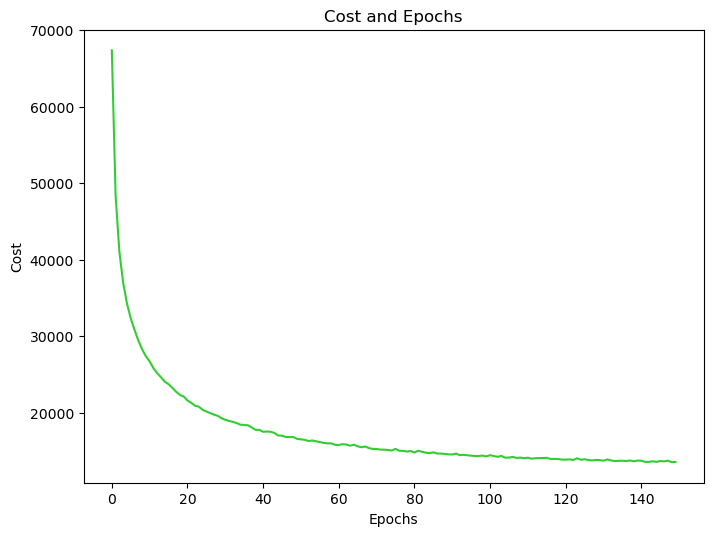

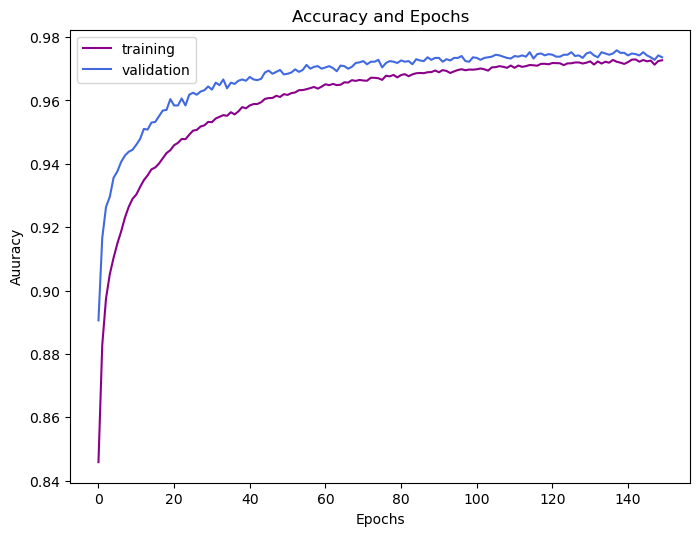

In [4]:
if __name__ == "__main__":  
    MNIST = MLPNeuralNetwork(
                     l2 = 0.08,
                     eta = 0.0005,
                     epochs = 150,
                     shuffle = True,
                     unit_hidden=100,
                     Random_seed = 1,
                     minibatch_size = 100,)
    MNIST.WeightInitialize(X_train,y_train)
    MNIST.BackPropagation(X_train = X_train[:55000],y_train = y_train[:55000],
                          X_valid = X_train[55000:],y_valid = y_train[55000:],)
    DrawCostLine()
    DrawAccuracyLine()

In [5]:
# Choose a random integer to test model.
i = np.random.randint(60000)
print(MNIST.Predict(X_train[i].reshape(1,784)))
print(y_train[i])

[8]
8


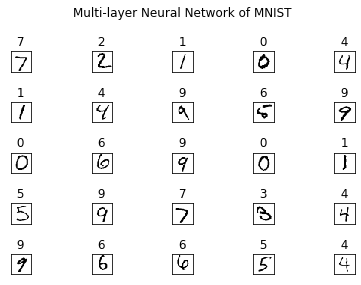

In [8]:
test_img = X_test[:25]
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
fig.suptitle("Multi-layer Neural Network of MNIST")
ax = ax.flatten()
for i in range(25):
    img = test_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(' {} '.format(MNIST.Predict(test_img[i].reshape(1,784))[0]))
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()